In [503]:
%%capture
!pip install ../opt

In [504]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('dark_background')

**Sphere function**
$f(x, y) = x^2 + y^2 \qquad
f(0, 0) = 0 \qquad
-\infty \leqslant x, y \leqslant \infty$

In [505]:
def f1(v):
    return v[0] ** 2 + v[1] ** 2

**Booth's function**
$f(x, y) = (x + 2y - 7)^2 + (2x + y - 5)^2 \qquad
f(1, 3) = 0 \qquad
-10 \leqslant x, y \leqslant 10$

In [506]:
def f2(v):
    return (v[0] + 2 * v[1] - 7) ** 2 + (2 * v[0] + v[1] - 5) ** 2

**Matyas function**
$\\$
$f(x, y) = 0.26 (x^2 + y^2) - 0.48 xy \qquad
f(0, 0) = 0 \qquad
-10 \leqslant x, y \leqslant 10$

In [507]:
def f3(v):
    return 0.26 * (v[0] ** 2 + v[1] ** 2) - 0.48 * v[0] * v[1]

$\displaystyle \nabla f(\boldsymbol{x}) =
\begin{pmatrix} \displaystyle \frac{\partial f}{\partial x_1}\\ \displaystyle \frac{\partial f}{\partial
x_2}\\ \vdots\\ \displaystyle \frac{\partial f}{\partial x_n} \end{pmatrix}$

$\displaystyle {\frac  {\partial f}{\partial x_{k}}}(x_{1},\cdots ,x_{n})=\lim _{{\Delta x\to 0}}{\frac  {f(x_{1},\ldots ,x_{k}+\Delta x,\ldots ,x_{n})-f(x_{1},\ldots ,x_{k},\ldots ,x_{n})}{\Delta x}}.$

In [508]:
delta_x = 1e-6


def derivative(f, v, i):
    upd_v = np.copy(v)
    upd_v[i] += delta_x
    return (f(upd_v) - f(v)) / delta_x


def gradient(f, v):
    return np.array([derivative(f, v, i) for i in range(len(v))])

In [509]:
def painter_decorator3d(func):
    @mpl.rc_context({
        'figure.figsize': (24, 16),
        'figure.facecolor': 'white',
        'figure.dpi': 80,
        'lines.linestyle': '--',
        'legend.fontsize': 0
    })
    def draw(*args, **kwargs):
        xk = func(*args, **kwargs)
        function = kwargs.get("f") if kwargs.get("f") else args[0]
        function_name = str(func).split()[1]
        xx = xk[:, 0]
        yy = xk[:, 1]
        zz = function(xk.T)

        lim = max(max(xx), max(yy)) + 2
        x = np.linspace(-lim, lim, 300)
        y = np.linspace(-lim, lim, 300)
        x, y = np.meshgrid(x, y)
        z = function(np.array([x, y]))

        axis_lim = (-lim, 2.5 * lim)
        axis = np.linspace(axis_lim[0], axis_lim[1], 2)
        zeros = np.zeros(2)
        figure = plt.figure(constrained_layout=True)
        figure.suptitle(function_name, color='black', fontsize=15)
        std_view = figure.add_subplot(121, projection='3d')
        std_view.plot_surface(x, y, z, alpha=0.7, cmap='cool')
        std_view.plot(xx, yy, zz, color='white', marker='.')
        std_view.plot(axis, zeros, zeros, color='grey')
        std_view.plot(zeros, axis, zeros, color='grey')
        std_view.scatter([0, axis_lim[1]], [axis_lim[1], 0], [0, 0], color='grey', marker='>', s=45)
        std_view.axis('off')

        upper_view = figure.add_subplot(122, aspect='equal')
        upper_view.contourf(x, y, z, alpha=.7, cmap='cool')
        upper_view.plot(xx, yy, marker='.', color='white')

    return draw

In [510]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from IPython.display import display

class Repository(object):
    methods = {}
    id = 0

    @classmethod
    def create(cls, method_name, constant_args, labels):
        """ Labels assignment """
        method_name = f'{method_name}_{cls.id}'
        cls.methods[method_name] = {
            'labels': [list(labels.keys())],
            'const_labels': [list(constant_args.keys())],
            'const_data': [list(constant_args.values())],
            'data': [list(labels.values())],
        }
        cls.id += 1
        return method_name

    @classmethod
    def save(cls, method_name, args):
        """ Saving new method iteration """
        cls.methods[method_name]['data'].append(args)

    @classmethod
    def visualize(cls, method_name):
        values = cls.methods[method_name]
        const_df = pd.DataFrame(data=values['const_data'], columns=values['const_labels'])
        main_df = pd.DataFrame(data=values['data'], columns=values['labels'])
        display(const_df)
        display(main_df)

## 1. Gradient descent with constant learning rate

$x_{k+1} = x_k - \lambda \nabla f(x_k), \qquad \lambda = const$

In [511]:
@painter_decorator3d
def gradient_descent_const(f, x0, learning_rate, tolerance=1e-4, n_iter=100):
    xk = np.array([x0], dtype=float)
    method_name = Repository.create('gradient_descent_const', {'tolerance': tolerance,' learning_rate': learning_rate}, {'x0': x0})
    for _ in range(n_iter):
        step = learning_rate * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        xk = np.append(xk, np.array([xk1]), axis=0)
        Repository.save(method_name, [xk[-1]])
    Repository.visualize(method_name)
    return xk

### Optimal learning rate

,tolerance,learning_rate
0,0.0001,0.2000


,x0
0,"[10.0, 10.0]"
1,"[5.999999805462721, 5.999999805462721]"
2,"[3.5999996836244463, 3.5999996836244463]"
3,"[2.159999609953047, 2.159999609953047]"
4,"[1.2959995661765333, 1.2959995661765333]"
5,"[0.7775995397152258, 0.7775995397152258]"
6,"[0.4665595237940323, 0.4665595237940323]"
7,"[0.27993551428128427, 0.27993551428128427]"
8,"[0.16796110857252522, 0.16796110857252522]"
9,"[0.10077646514338401, 0.10077646514338401]"


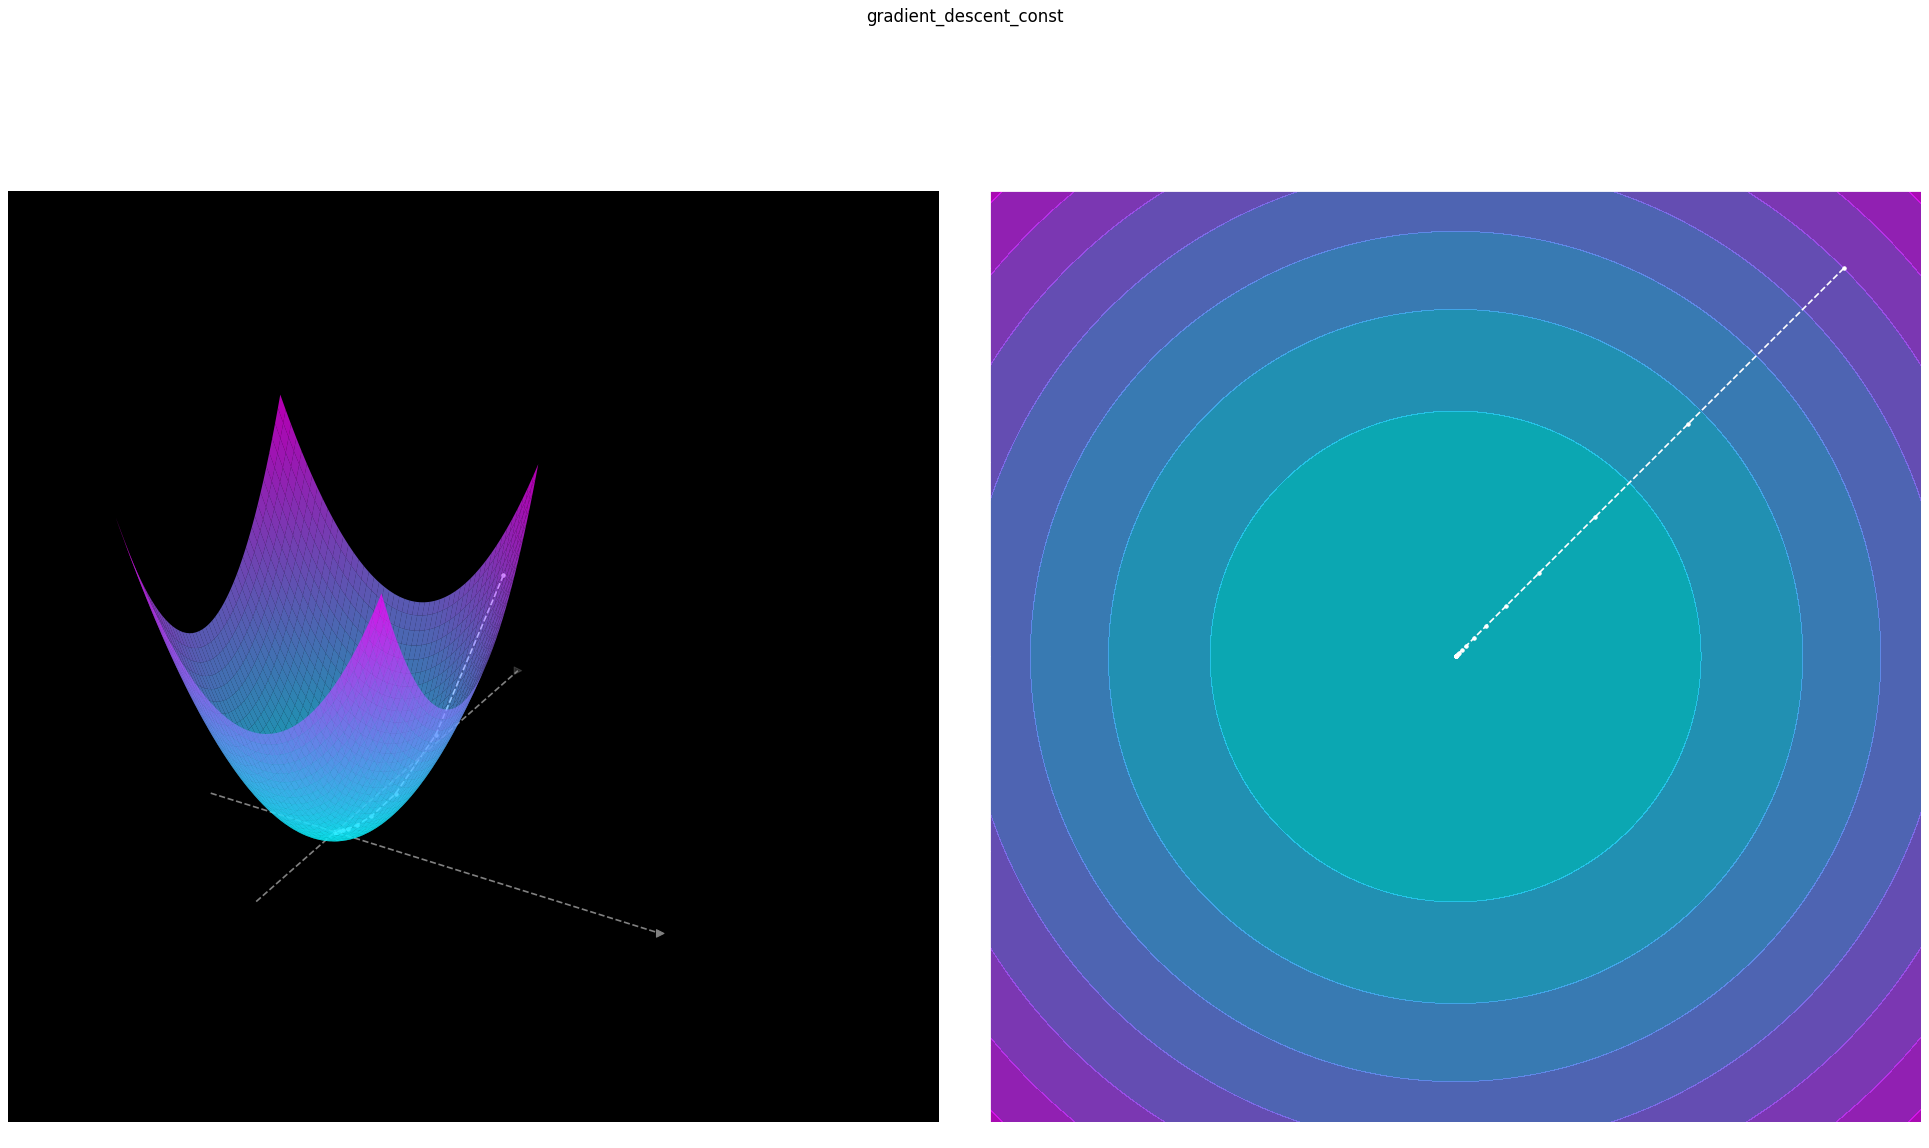

In [512]:
gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.2)

### Large learning rate

,tolerance,learning_rate
0,0.0001,0.9000


,x0
0,"[10.0, 10.0]"
1,"[-8.000000875417754, -8.000000875417754]"
2,"[6.399999804452818, 6.399999804452818]"
3,"[-5.12000073944364, -5.12000073944364]"
4,"[4.095999696952504, 4.095999696952504]"
5,"[-3.2768006572803188, -3.2768006572803188]"
6,"[2.621439626105939, 2.621439626105939]"
7,"[-2.0971526012425556, -2.0971526012425556]"
8,"[1.6777211819152171, 1.6777211819152171]"
9,"[-1.3421778449307453, -1.3421778449307453]"


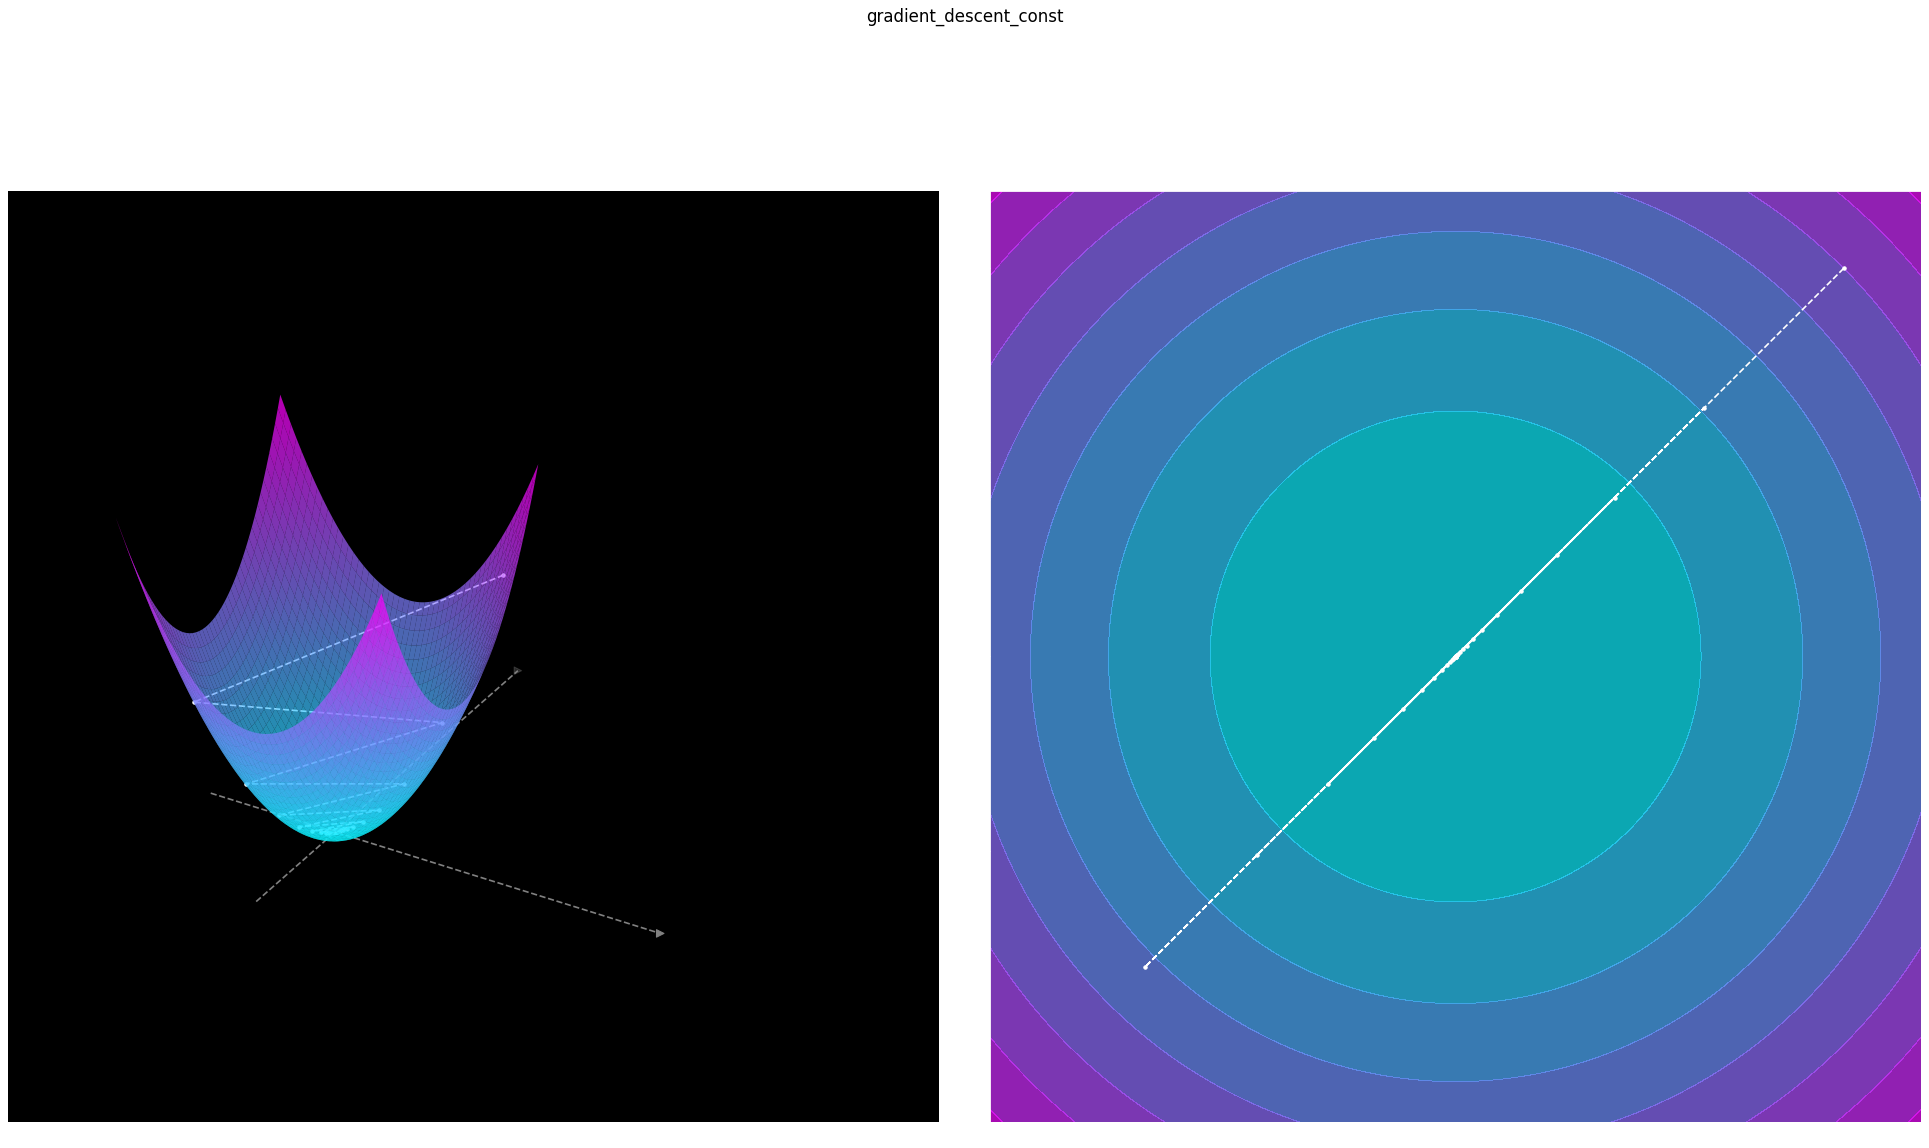

In [513]:
gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.9)

### Small learning rate

,tolerance,learning_rate
0,0.0001,0.0100


,x0
0,"[10.0, 10.0]"
1,"[9.799999990273136, 9.799999990273136]"
2,"[9.603999980593017, 9.603999980593017]"
3,"[9.411919970953022, 9.411919970953022]"
4,"[9.223681561772992, 9.223681561772992]"
...,...
96,"[1.4378154207739158, 1.4378154207739158]"
97,"[1.4090591023541066, 1.4090591023541066]"
98,"[1.3808779103119306, 1.3808779103119306]"
99,"[1.3532603421062461, 1.3532603421062461]"


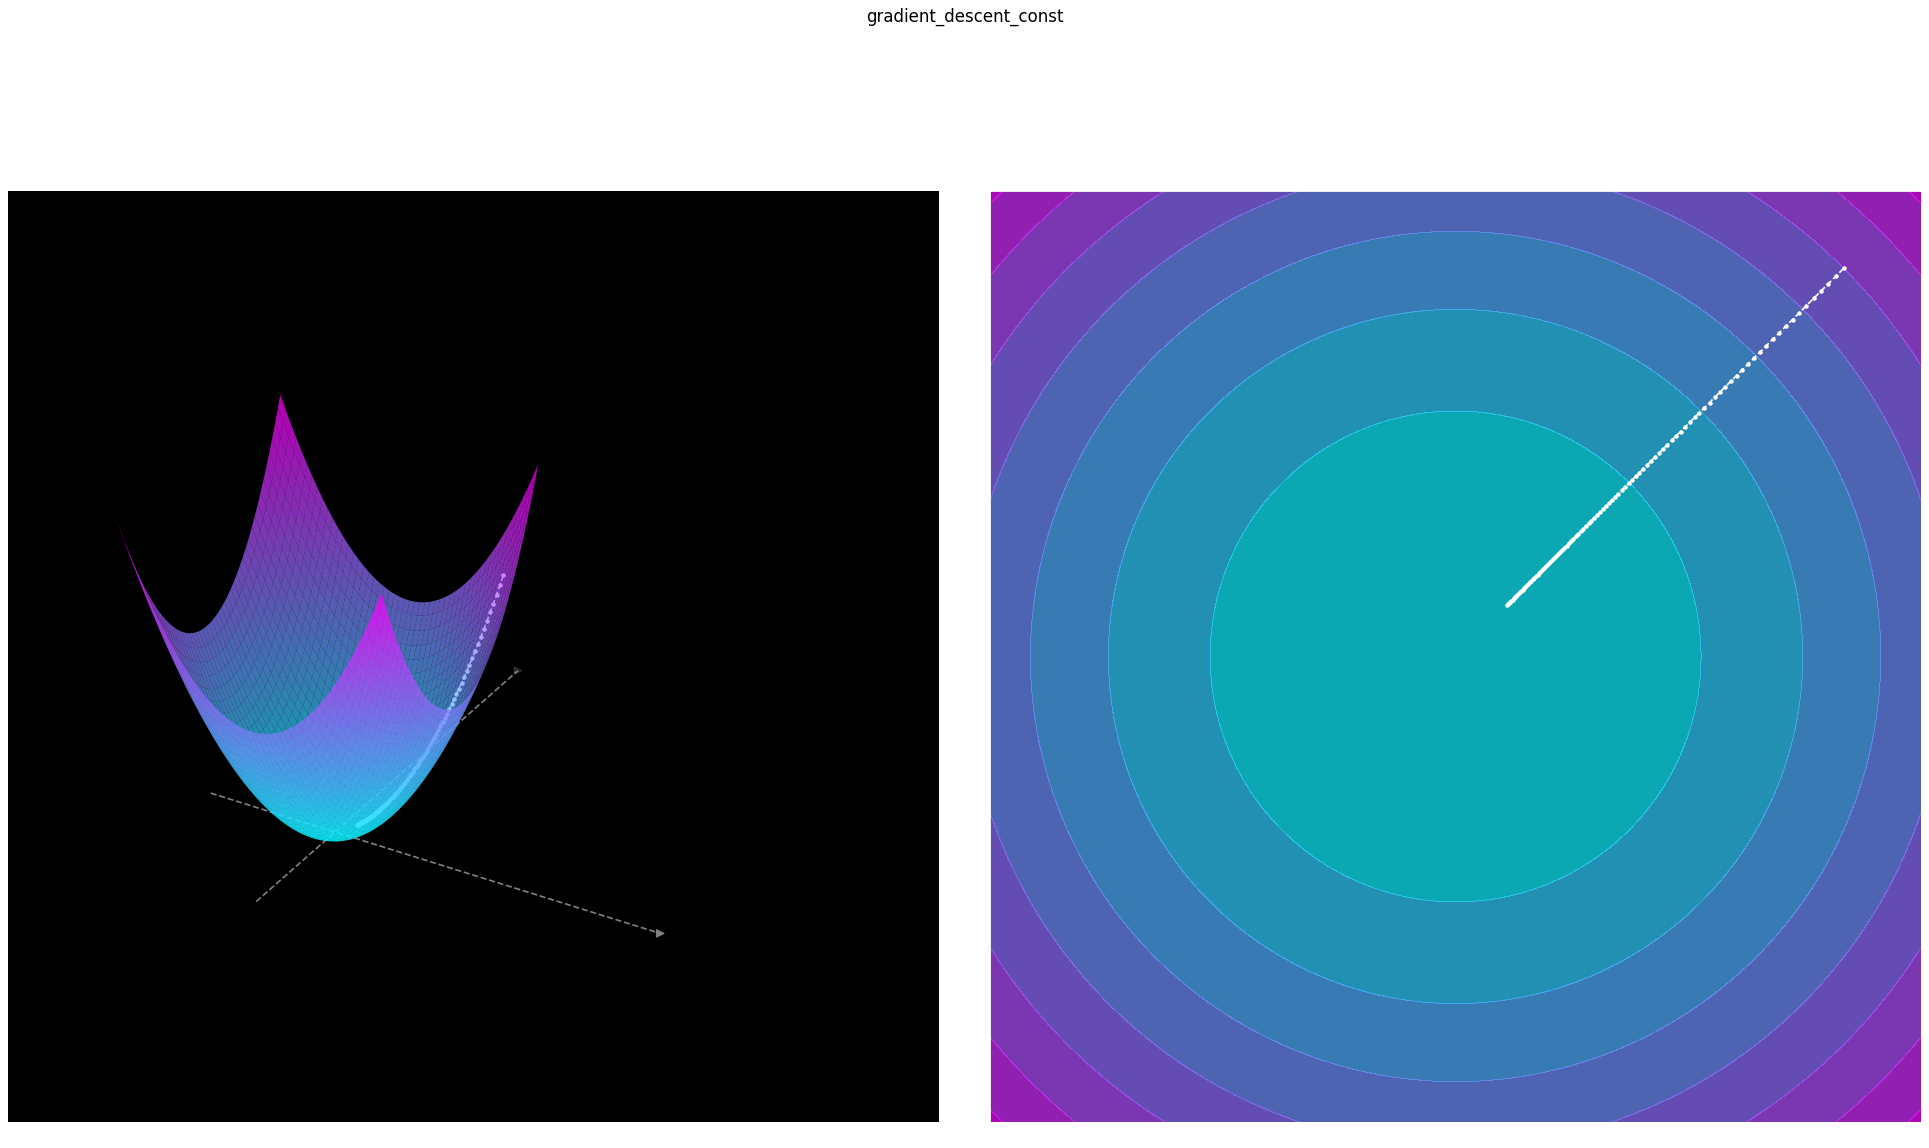

In [514]:
gradient_descent_const(f1, np.array([10, 10], dtype=float), 0.01)

## 2. Gradient descent with "step crushing" - метод дробления шага

$\displaystyle f(x_{k+1}) = f(x_k - \lambda_{k}\nabla f(x_k)) \leqslant f(x_k) - \varepsilon \lambda_{k} \| \nabla f(x_k) \|^2, \ \ \displaystyle \varepsilon \in (0, 1)$

$False$: $\lambda_k \rightarrow \frac{\lambda_k}{\delta}, \ \ \delta \in (0, 1)$

In [515]:
from numpy.linalg import norm


@painter_decorator3d
def gradient_descent_step_crushing(f, x0, learning_rate=1, tolerance=1e-4, n_iter=100, eps=0.1, delta=0.95):
    xk = np.array([x0], dtype=float)
    fxk = f(x0)
    i, lr = 0, learning_rate
    while i < n_iter:
        step = lr * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        fxk1 = f(xk1)
        if fxk1 - fxk > -eps * lr * (norm(gradient(f, xk[-1]), 2) ** 2):
            lr *= delta
            continue

        xk = np.append(xk, np.array([xk1]), axis=0)
        fxk = fxk1
        lr = learning_rate
        i += 1
    return xk

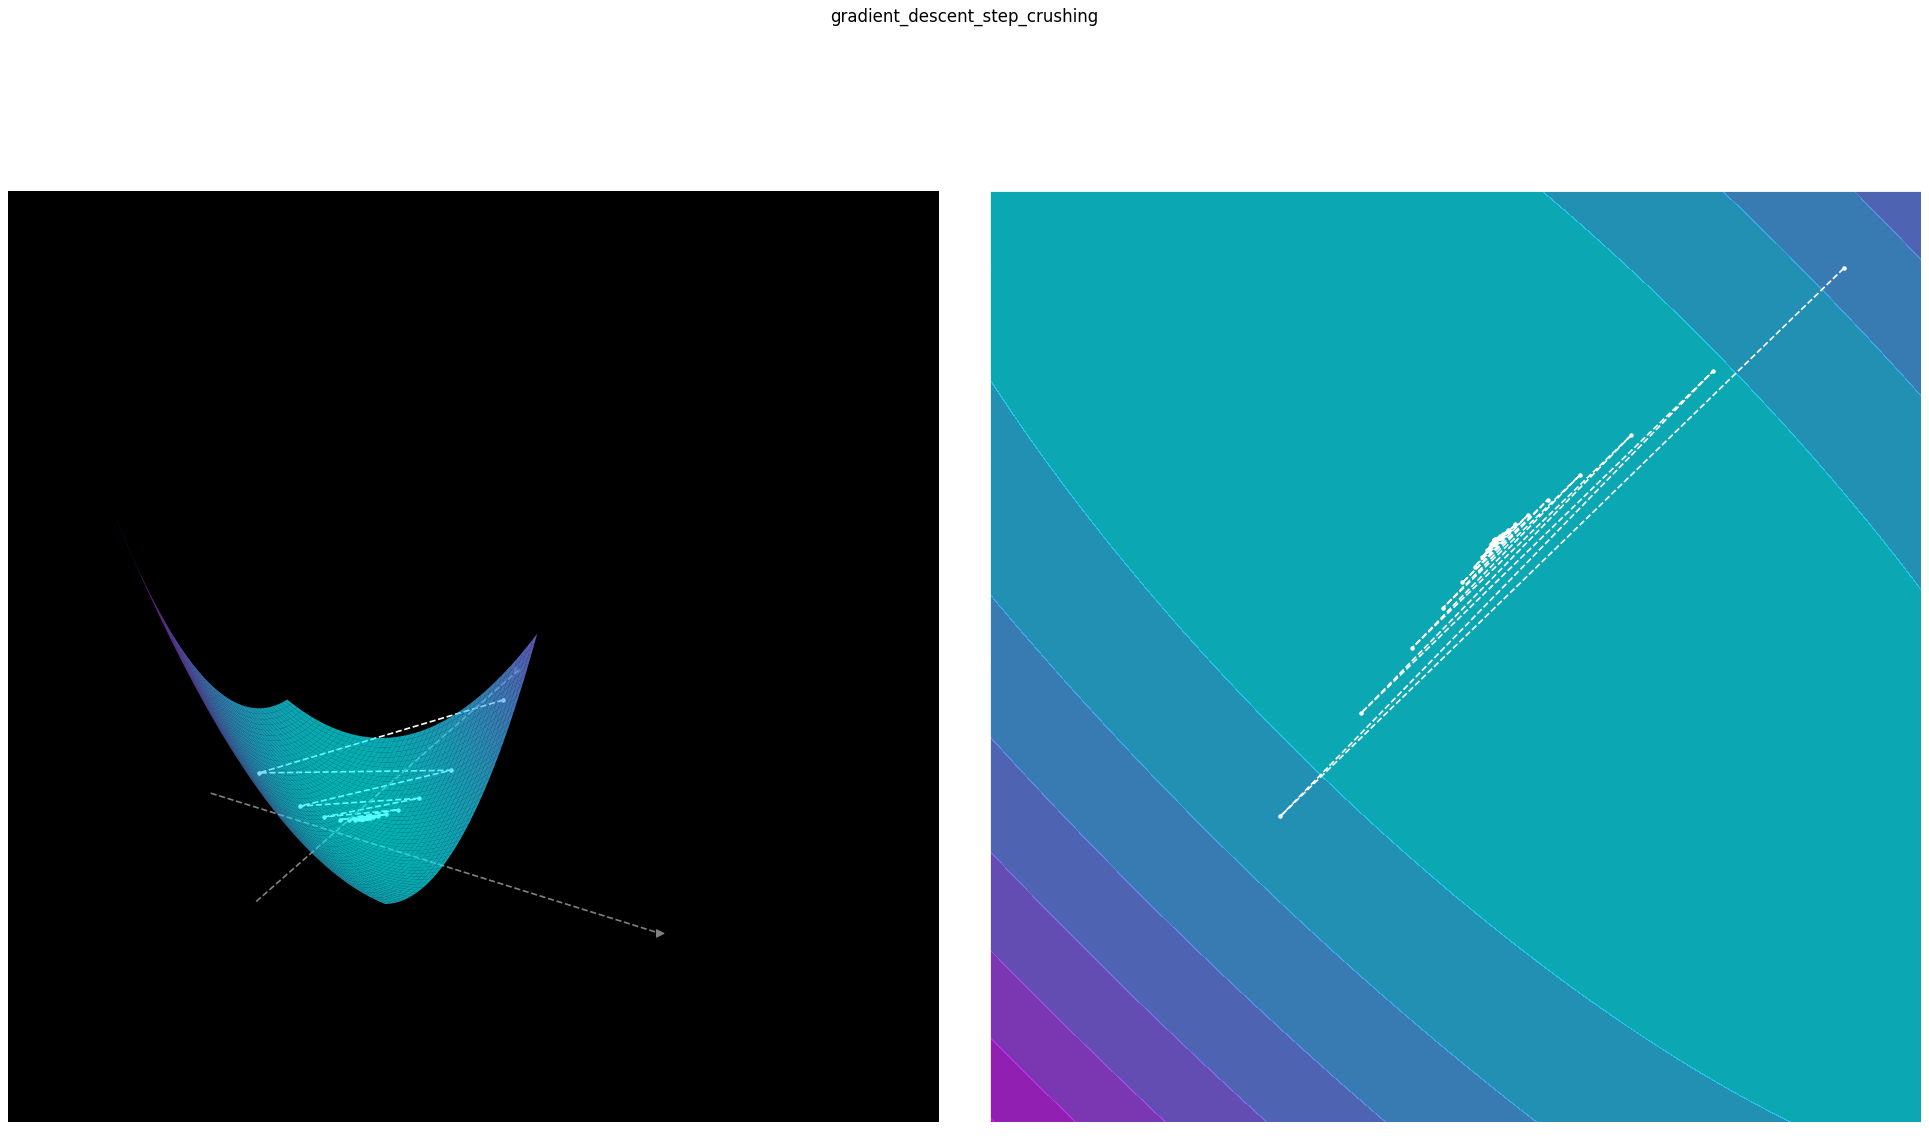

In [516]:
gradient_descent_step_crushing(f2, np.array([10, 10], dtype=float), 1)

## 3. Gradient descent with 1D optimization techniques

$\displaystyle \lambda_k = \arg_{\lambda \in [0, +\inf)} \min \ f(x_k - \lambda \nabla f(x_k))$

In [517]:
from opt_algo.opt_1d import *


@painter_decorator3d
def gradient_descent_opt1d(f, opt_method, x0, tolerance=1e-4, n_iter=100):
    xk = np.array([x0], dtype=float)
    l, r = 0, 1e6
    for _ in range(n_iter):
        learning_rate = opt_method(lambda lr: f(xk[-1] - lr * gradient(f, xk[-1])), l, r, eps=tolerance)
        step = learning_rate * gradient(f, xk[-1])
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        xk = np.append(xk, np.array([xk1]), axis=0)
    return xk

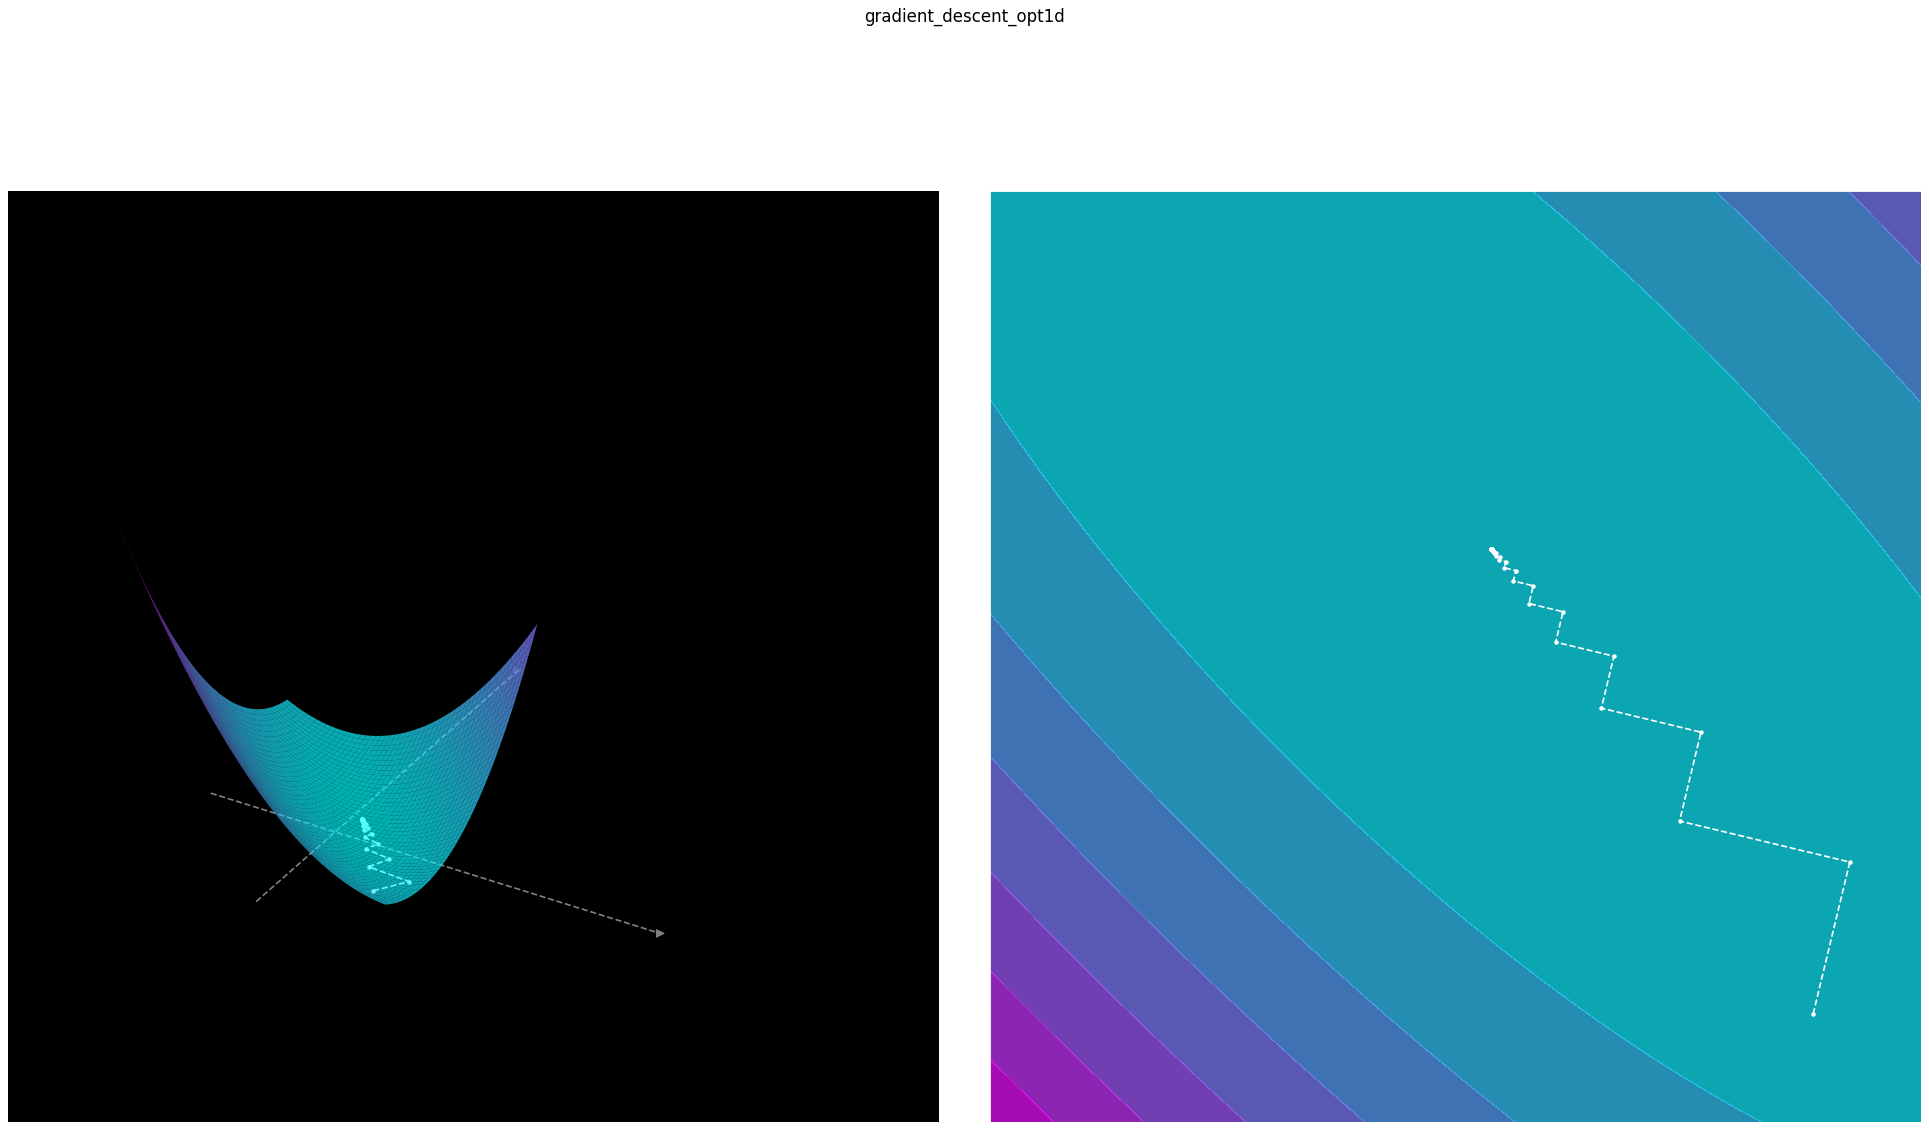

In [518]:
gradient_descent_opt1d(f2, golden_section_search, np.array([10, -10], dtype=float))

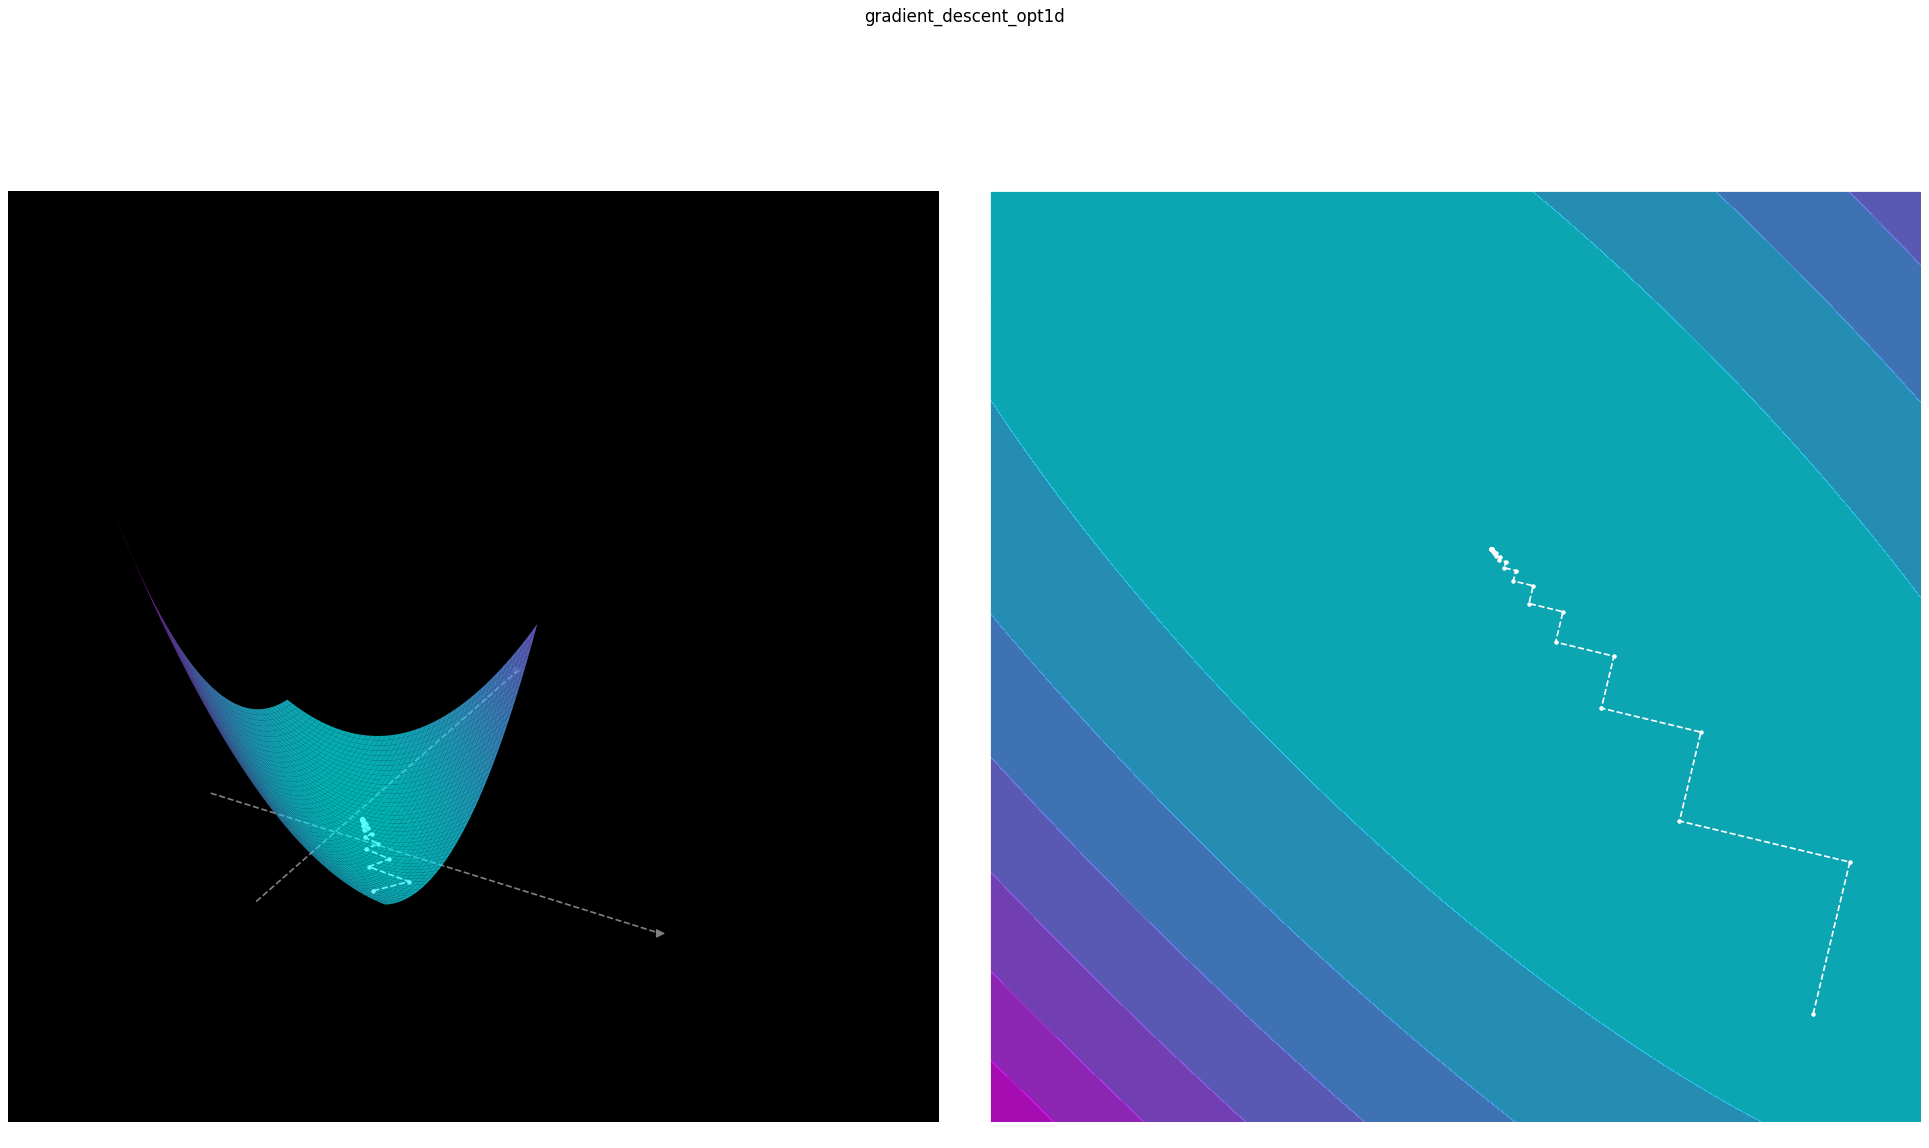

In [519]:
gradient_descent_opt1d(f2, fibonacci_search, np.array([10, -10], dtype=float))

## 4. Fletcher-Reeves Method

${\displaystyle
\vec{x}_{k+1} = \vec{x}_{k} - \lambda_{k+1} \vec{S}_{k} \qquad
\vec{S}_{k+1}=\nabla f({\vec{x}_{k+1}})+\omega _{k+1}{\vec {S}}_{k} \qquad
\omega _{k+1}={\frac {\|\nabla f({\vec{x}_{k+1}})\|^{2}}{\|\nabla f({\vec {x}}_{k})\|^{2}}}}\qquad
\lambda_k = \arg_{\lambda \in [0, +\inf)} \min \ f(x_k - \lambda S_k)
$

In [520]:
@painter_decorator3d
def gradient_descent_fletcher_reeves(f, opt_method, x0, tolerance=1e-4, n_iter=100):
    xk = np.array([x0], dtype=float)
    wk, sk = 0, gradient(f, x0)
    l, r = 0, 1e6

    for _ in range(n_iter):
        learning_rate = opt_method(lambda lr: f(xk[-1] - lr * sk), l, r, eps=tolerance)
        step = learning_rate * sk
        if np.all(np.abs(step) < tolerance):
            break

        xk1 = xk[-1] - step
        wk1 = (norm(gradient(f, xk1), 2) ** 2) / (norm(gradient(f, xk[-1]), 2) ** 2)
        sk1 = gradient(f, xk1) + wk1 * sk
        sk, wk = sk1, wk1
        xk = np.append(xk, np.array([xk1]), axis=0)
    return xk

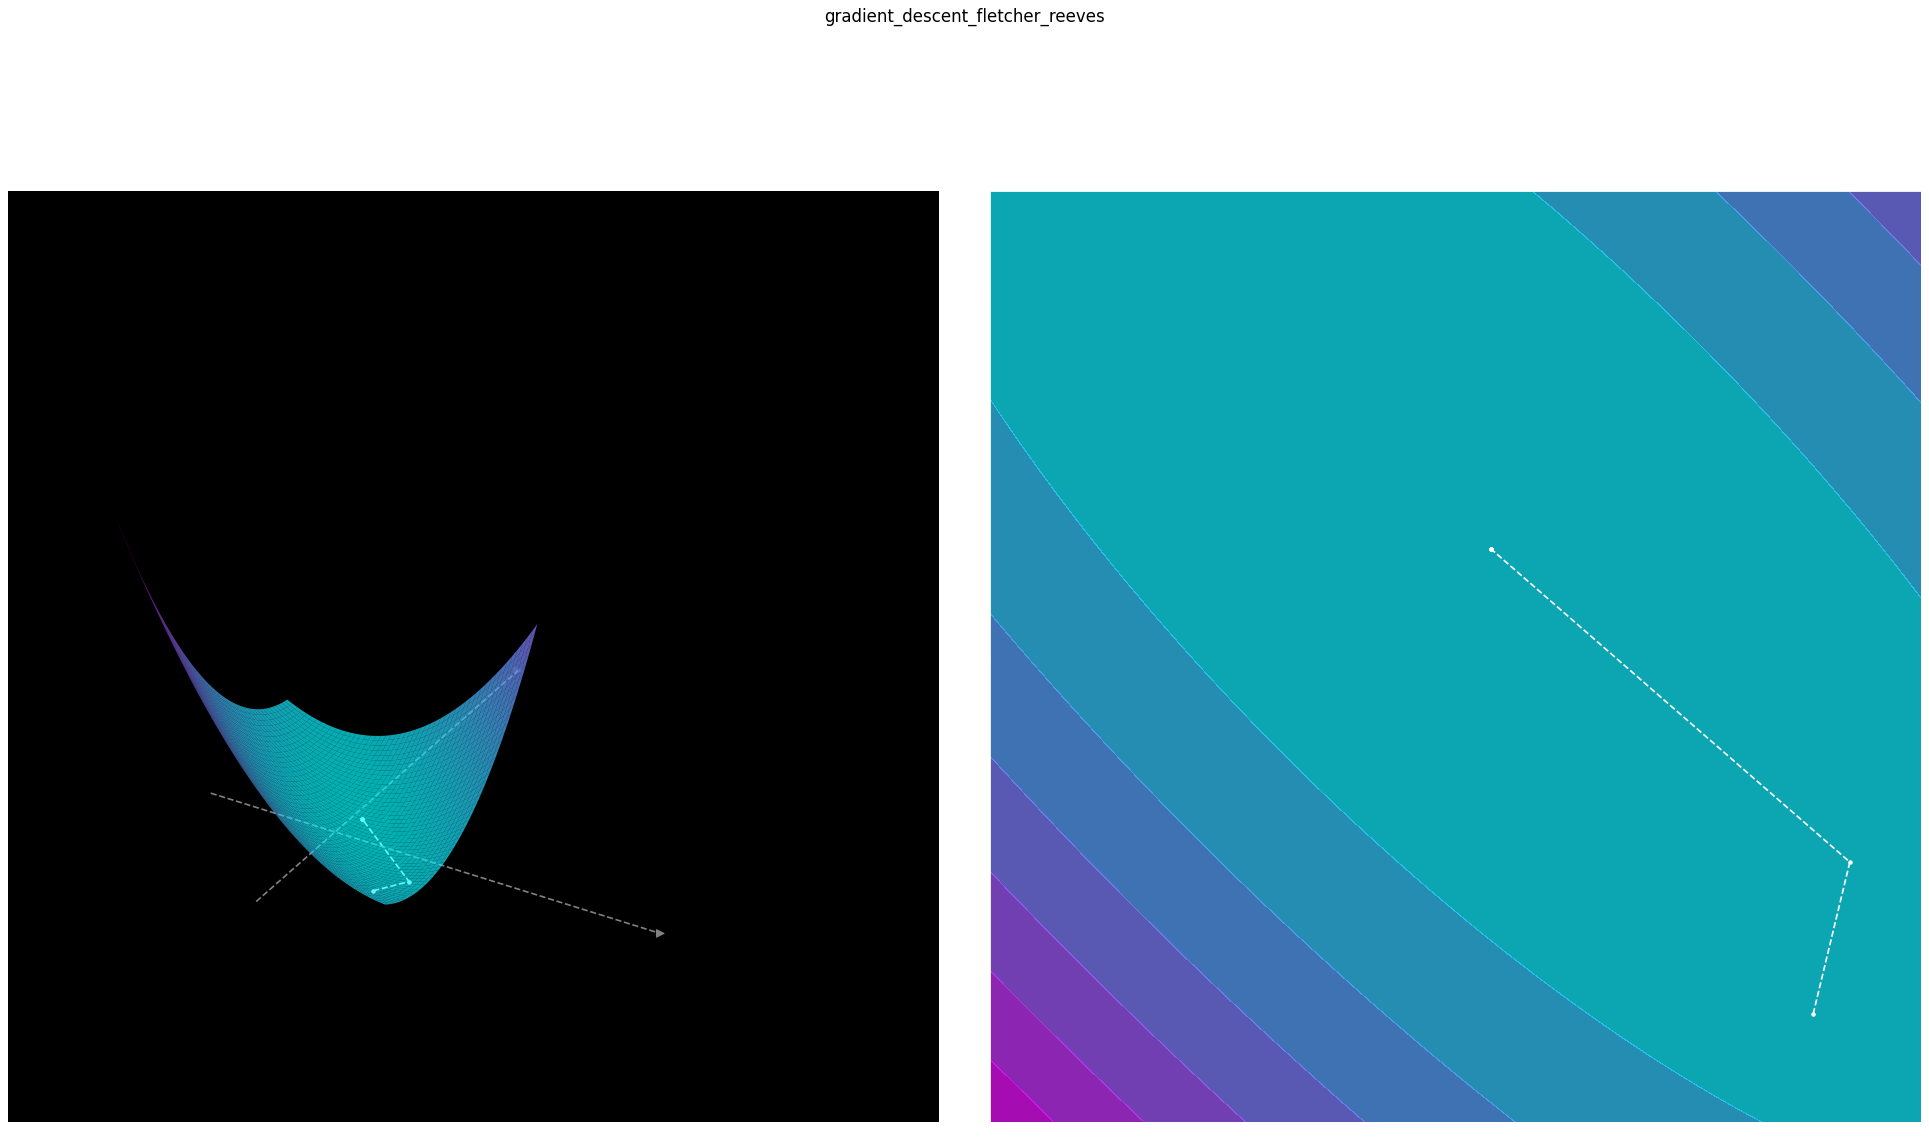

In [521]:
gradient_descent_fletcher_reeves(f2, golden_section_search, np.array([10, -10], dtype=float))

## 5. Analysis

In [522]:
def analyze(**kwargs):
    """
    Comparison of gradient descent functions\n
    ...\n
    kwargs:\n
    gradient_descent -- gradient descent methods\n
    functions -- functions to compare\n
    """
    gds = kwargs.get('gradient_descent')
    fs = kwargs.get('functions')
    print(gds, fs)
    assert gds, 'Couldn\'t find gradient descent methods!'
    assert fs, 'Couldn\'t find functions for analysis!'

    # for gd in gds:


    # \lambda
    # \iter
    # \tolerance